### Some Prerequisites

In [84]:
import pathlib
import math
from datetime import datetime
import re
import json

from ipyfilechooser import FileChooser
import rasterio
from rasterio.mask import mask
from shapely import geometry
from osgeo import gdal
import pandas as pd
import numpy as np
import dask.distributed
from skimage.registration import phase_cross_correlation
import matplotlib.pyplot as plt

import opensarlab_lib as asfn

%matplotlib inline

In [2]:
# Get working directory of notebook
CWD = pathlib.Path().absolute()
CWD

# Set some paths to be used later
!mkdir -p "{CWD}/work/"

ORIGINAL_DIR = CWD / "work/original"
!mkdir -p "{CWD}/work/original"

SUPERSET_DIR = CWD / "work/superset"
!mkdir -p "{CWD}/work/superset"

FLATTEN_DIR = CWD / "work/flatten"
!mkdir -p "{CWD}/work/flatten"

TILES_DIR = CWD / "work/tiles"
!mkdir -p "{CWD}/work/tiles"

RESULTS_DIR = CWD / "work/correlation"
!mkdir -p "{CWD}/work/correlation"

### 1. Select VVs

Choose the parent directory of all child directories contain the stack of VVs

#### Clear out work directory

In [ ]:
clear_out = input("Clear out work directory? (YES, NO)")

if clear_out == 'YES':
    !rm -rf "{CWD}/work/*"

In [ ]:
fc = FileChooser(f'{CWD}/data/')
fc.show_only_dirs = True
display(fc)

In [ ]:
parent_directory = pathlib.Path(fc.selected_path).absolute()

# Find all VVs within
all_vv_paths = parent_directory.glob(f"**/*_VV.tif")
print(list(all_vv_paths))

# Move desired products to work directory.
for source_path in all_vv_paths:
    print(f"Copying {source_path} to {CWD}/work/original/{source_path.name}")
    !cp "{source_path}" "{CWD}/work/original/{source_path.name}"

### 2. Superset VVs

Scene frames have a tendency to move over time. This means that the extant coverage for the whole scene is always different per frame. For the cross-correlation to properly work and for more accurate comparison, all the scenes need to be "normalized" by increasing/decreasing the size of the square extant. 

From extant metadata, get the full superset coordinates for all stack scenes.

In [ ]:
# Open all the tiffs and get overall coords.
superset = {
    'left': math.inf,
    'bottom': math.inf,
    'right': -math.inf,
    'top': -math.inf
}

# The SRS is set to the first raster. It is assumed that the SRSs are the same (or close enough) for all.
output_srs = None

vv_original_paths = pathlib.Path(f"{CWD}/work/original").glob(f"*_VV.tif")

for i, original_path in enumerate(vv_original_paths):

    raster = rasterio.open(original_path)    
    raster_bounds = raster.bounds
    print(raster_bounds)
    
    if i == 0:
        output_srs = raster.crs
    
    superset = {
        'left': min(superset['left'], raster_bounds.left),
        'bottom': min(superset['bottom'], raster_bounds.bottom), 
        'right': max(superset['right'], raster_bounds.right), 
        'top': max(superset['top'], raster_bounds.top)
    }

print(f"Superset box coords: {superset}")
print(f"Output SRS: {output_srs}")

In [ ]:
output_bounds = (
            superset['left'], 
            superset['bottom'],
            superset['right'],
            superset['top'],
        )

print(f"Output bounds (superset) set to '{output_bounds}'")
print(f"Output SRS set to '{output_srs}'")

# Superset and save VVs
vv_original_paths = pathlib.Path(f"{CWD}/work/original").glob(f"*_VV.tif")
for original_path in vv_original_paths:
    
    superset_path = pathlib.Path(str(original_path).replace('original', 'superset'))
    print(f"Taking {original_path} and supersetting to {superset_path}")
    
    gdal.Warp(
        str(superset_path),
        str(original_path), 
        outputBounds=output_bounds,
        outputBoundsSRS=output_srs
    )
    

### 3. Flatten and Save VVs

Often the VVs have extraneous high and low values that make matching difficult. So we need to get rid of these and save the intermediate results.

In [ ]:
def flatten(df: pd.DataFrame) -> pd.DataFrame:
    """
    Truncated values become NaNs
    """
    df[df < np.nanpercentile(df, 1)] = np.nan
    df[df > np.nanpercentile(df, 99)] = np.nan
    return df

# Flatten and save VVs
superset_vv_paths = pathlib.Path(f"{CWD}/work/superset").glob(f"*_VV.tif")

for superset_path in superset_vv_paths:
    print(f"Flattening {superset_path}")
    
    # Convert raster to dataframe
    raster = rasterio.open(superset_path)
    raster_metadata = raster.meta

    raster0 = raster.read(1)
    df_superset = pd.DataFrame(raster0)
    
    # Flatten raster data
    df_flatten = flatten(df_superset)
    
    flatten_path = pathlib.Path(str(superset_path).replace('superset', 'flatten'))
    
    with rasterio.open(flatten_path, 'w', **raster_metadata) as out:
        out.write(df_flatten, 1)

### 4. Tile and Save VVs

In [ ]:
X_NUM = 8
Y_NUM = 8

# https://gis.stackexchange.com/a/306862
# Takes a Rasterio dataset and splits it into squares of dimensions squareDim * squareDim
def splitImageIntoCells(input_number: int, input_file: str, output_dir: str, x_num=1, y_num=1):
    """
    input_number: A sequential number representing the ordering of the scenes. This is to make later scene pairing easier.
    input_file: Full file path of scene to be tiled.
    output_dir: Full path of directory to place tiles.
    x_num: Number of tiles formed in the x direction per scene.
    y_num: Number of tiles formed in the y direction per scene.
    """

    raster = rasterio.open(input_file)
    
    x_dim = raster.shape[1] // x_num
    y_dim = raster.shape[0] // y_num

    x, y = 0, 0
    for y_iter in range(y_num):
        y = y_iter * y_dim
        for x_iter in range(x_num):
            x = x_iter * x_dim
            
            input_filestem = pathlib.Path(input_file).stem
            
            output_file = f'{input_filestem}_{input_number}_{y_iter}_{x_iter}.tif'
            print(f"Creating tile {output_file}...")
            
            # Get tile geometry
            corner1 = raster.transform * (x, y)
            corner2 = raster.transform * (x + x_dim, y + y_dim)
            geom = geometry.box(corner1[0], corner1[1], corner2[0], corner2[1])
            
            # Get cell 
            crop, cropTransform = mask(raster, [geom], crop=True)
            raster.meta.update(
                {
                    "driver": "GTiff",
                    "height": crop.shape[1],
                    "width": crop.shape[2],
                    "transform": cropTransform,
                    "crs": raster.crs
                }
            )
                        
            output_filepath = f"{output_dir}/{output_file}"
            with rasterio.open(output_filepath, "w", **raster.meta) as out:
                out.write(crop)

In [ ]:
flatten_vv_paths = pathlib.Path(f"{CWD}/work/flatten").glob(f"*_VV.tif")

start_time = datetime.now()

for i, flatten_path in enumerate(flatten_vv_paths):
    print(f"Tileing {flatten_path}")
    splitImageIntoCells(i, flatten_path, f"{CWD}/work/tiles", x_num=X_NUM, y_num=Y_NUM)
    
end_time = datetime.now()
print(f"\nEnd time is {end_time}")
print(f"Time elapsed is {end_time - start_time}\n")  

### 5. Correlate Tiles and Save Results

In [ ]:
def setup_dask() -> dask.distributed.Client:
    
    RAM_PER_WORKER_GB = 20
    NUM_WORKERS = 10
    NUM_THREADS_PER_WORKER = 2

    cluster = dask.distributed.LocalCluster(
        threads_per_worker=NUM_THREADS_PER_WORKER,
        n_workers=NUM_WORKERS,
        memory_limit=f"{RAM_PER_WORKER_GB}GB",
        processes=True
    )

    return dask.distributed.Client(cluster)

def teardown_dask(client: dask.distributed.Client) -> None:
    client.shutdown()

def do_dask(client: dask.distributed.Client, callback, args: list):
    try:
        futures = client.map(callback, args)
        dask.distributed.progress(futures)
    except Exception as e:
        print(f"Error in dask: {e}")
        teardown_dask(client)
        return 
    
    return client.gather(futures)

In [ ]:
def get_correlation_args() -> list:
    """
    return [
        {
            'reference_index': '',
            'secondary_index': '',
            'tile_number_x': '',
            'tile_number_y': '',
            'ref_file_path': '',
            'sec_file_path': ''
        },
    ]
    """
    
    tiles_paths = pathlib.Path(f"{CWD}/work/tiles").glob(f"*.tif")
    tiles = []

    # Get index and tile numbers from path
    for tiles_path in tiles_paths:

        m = re.match(r".*_([0-9]+)_([0-9]+)_([0-9]+).tif", tiles_path.name)

        tiles.append({
            'index': m.group(1),
            'tile_number_x': m.group(2),
            'tile_number_y': m.group(3),
            'file_path': tiles_path
        })

    tiles_df = pd.DataFrame(tiles).sort_values(by=['tile_number_x', 'tile_number_y', 'index'])

    paris = []
    for i in range(len(tiles_df.index) - 1):

        ref_row = tiles_df.iloc[i]
        sec_row = tiles_df.iloc[i+1]

        # If the next row in the sorted dataframe has different tile numbers, then we are at a new set
        if ref_row['tile_number_x'] != sec_row['tile_number_x'] or ref_row['tile_number_y'] != sec_row['tile_number_y']:
            continue

        paris.append({
            'reference_index': ref_row['index'],
            'secondary_index': sec_row['index'],
            'tile_number_x': ref_row['tile_number_x'],
            'tile_number_y': ref_row['tile_number_y'],
            'ref_file_path': ref_row['file_path'],
            'sec_file_path': sec_row['file_path']
        })

    return paris

def correlation_callback(args: dict) -> dict:
    """
    args = {
        'reference_index': '',
        'secondary_index': '',
        'tile_number_x': '',
        'tile_number_y': '',
        'ref_file_path': '',
        'sec_file_path': ''
    }
    """
    
    try:
        reference_index = args['reference_index']
        secondary_index = args['secondary_index']
        tile_number_x = args['tile_number_x']
        tile_number_y = args['tile_number_y']
        ref_file_path = args['ref_file_path']
        sec_file_path = args['sec_file_path']

        ###### Reference 
        stime = datetime.now()
        print(f"\nIndex {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Rendering {ref_file_path}...")
        rast = rasterio.open(ref_file_path)
        raster0 = rast.read(1)
        df_ref = pd.DataFrame(raster0)
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Time to complete ref: {datetime.now() - stime}")


        ###### Secondary
        stime = datetime.now()
        print(f"\nIndex {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Rendering {sec_file_path}...")
        rast = rasterio.open(sec_file_path)
        raster0 = rast.read(1)
        df_sec = pd.DataFrame(raster0)
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Time to complete sec: {datetime.now() - stime}")


        ###### If crop tile is more than 10% NANs, skip correlation and set return values to NaN 
        def get_percent_nans(df):
            number_of_elements = df.size
            number_of_nans = df.isnull().sum().sum()

            return number_of_nans / number_of_elements

        percent_nans_ref = get_percent_nans(df_ref)
        percent_nans_sec = get_percent_nans(df_sec)

        if percent_nans_ref > 0.10 or percent_nans_sec > 0.10:
            print(f"\nIndex {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Too many NaNs. Skipping correlation....")

            result = {
                "reference_index": int(reference_index),
                "secondary_index": int(secondary_index),
                "tile_number_x": int(tile_number_x),
                "tile_number_y": int(tile_number_y),
                "ref_file": str(ref_file_path),
                "sec_file": str(sec_file_path),
                "shift_x": np.nan,
                "shift_y": np.nan, 
                "error": np.nan, 
                "phase": np.nan,
                "message": "Too many NaNs"
            }

        ####### Cross corr without masking
        stime = datetime.now()
        print(f"\nIndex {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Finding phase correlation with nans set to zero....")
        shift, error, phase = phase_cross_correlation(

            df_ref.replace(np.nan, 0), 
            df_sec.replace(np.nan, 0),

            normalization=None
        )
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Shift vector (in pixels) required to register moving_image with reference_image: {shift}")
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Translation invariant normalized RMS error between reference_image and moving_image: {error}")
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Global phase difference between the two images (should be zero if images are non-negative).: {phase}\n")

        if len(list(shift)) != 2:
            result = {
                "reference_index": int(reference_index),
                "secondary_index": int(secondary_index),
                "tile_number_x": int(tile_number_x),
                "tile_number_y": int(tile_number_y),
                "ref_file": str(ref_file_path),
                "sec_file": str(sec_file_path),
                "shift_x": int(shift[0]),
                "shift_y": int(shift[1]),
                "error": np.nan, 
                "phase": np.nan,
                "message": "Shift is not a two element array"
            }
        
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}:  Time to complete correlation: {datetime.now() - stime}")


        ####### Write metadata to correlation result files

        result = {
            "reference_index": int(reference_index),
            "secondary_index": int(secondary_index),
            "tile_number_x": int(tile_number_x),
            "tile_number_y": int(tile_number_y),
            "ref_file": str(ref_file_path),
            "sec_file": str(sec_file_path),
            "shift_x": int(shift[0]),
            "shift_y": int(shift[1]),
            "error": np.float64(error), 
            "phase": np.float64(phase),
            "message": "Correlation successful"
        }

    except Exception as e:
        print(f"An error occurred: {e}")
        result = {
            "reference_index": int(reference_index),
            "secondary_index": int(secondary_index),
            "tile_number_x": int(tile_number_x),
            "tile_number_y": int(tile_number_y),
            "ref_file": str(ref_file_path),
            "sec_file": str(sec_file_path),
            "shift_x": np.nan, 
            "shift_y": np.nan,
            "error": np.nan, 
            "phase": np.nan,
            "message": f"Error: {e}"
        }
        
    try:
        result_file = pathlib.Path(f"{CWD}/work/correlation/index_{reference_index}_{secondary_index}-tile_{tile_number_x}_{tile_number_y}.json")
        with open(result_file, 'w') as f:
            json.dump(result, f)
    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
start_time = datetime.now()
print(f"\nStart time is {start_time}")

client = setup_dask()
correlation_results = do_dask(client, correlation_callback, get_correlation_args())

teardown_dask(client)

end_time = datetime.now()
print(f"\nEnd time is {end_time}")
print(f"Time elapsed is {end_time - start_time}\n")  

### 6. Do Anaylsis on Tiles

Read the correlation result files from the previous section into a Pandas DataFrame.

Then perform various statistical analyses.

In [39]:
# Put results into 3D Pandas dataset
correlation_paths = pathlib.Path(f"{CWD}/work/correlation").glob(f"*.json")

results = []

for corr_path in correlation_paths:
    with open(corr_path, 'r') as f:
        results.append(json.load(f))

results_df = pd.DataFrame(results)

# Do analysis:
# 1. Slice mean and stdev - Combine all tiles per scene pair, i.e. (reference_index, secondary_index) are the same.
paired_df = results_df.groupby(by=['reference_index'])

# 2. Temporal trend mean and stdev
temporal_df = results_df.groupby(by=['tile_number_x', 'tile_number_y'])

# 3. Global mean and stdev
global_df = results_df.groupby(by=['reference_index', 'tile_number_x', 'tile_number_y'])

In [35]:
display(results_df)

,reference_index,secondary_index,tile_number_x,tile_number_y,ref_file,sec_file,shift_x,shift_y,error,phase,message
0,0,1,1,4,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,0,0,0.302493,-1.468360e-08,Correlation successful
1,4,5,4,1,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,0,0,0.401382,1.734200e-07,Correlation successful
2,0,1,3,6,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,0,0,0.353742,2.109810e-09,Correlation successful
3,4,5,5,2,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,0,0,0.421153,1.639353e-07,Correlation successful
4,1,2,2,7,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,0,0,0.329726,1.064571e-07,Correlation successful
...,...,...,...,...,...,...,...,...,...,...,...
314,2,3,5,5,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,0,0,0.488341,5.663321e-08,Correlation successful
315,2,3,3,4,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,0,0,0.463408,8.763492e-08,Correlation successful
316,0,1,0,5,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,0,0,0.310509,5.434967e-08,Correlation successful
317,1,2,1,1,/home/jovyan/calval-RTC/cross_correlation_rela...,/home/jovyan/calval-RTC/cross_correlation_rela...,0,0,0.292022,-1.362969e-07,Correlation successful


Display the stats for the shift, error, and phase of the cross-correlation between two scenes in the stack.

The `reference_index` is the order number of the reference scene within the stack. The stack scenes are ordered from newest to oldest.
The `secondary_index` is the order number of the secondary scene within the stack.

The `mean` value is a simple mean of all tile values. Similarity for `std`, etc.

,tile_mean_x,tile_mean_y,error
reference_index,,,
0,0.00,0.0,3.258629
1,0.00,0.0,3.164675
2,-0.25,0.0,3.444654
3,0.00,0.0,3.418582
4,0.00,0.0,2.928903


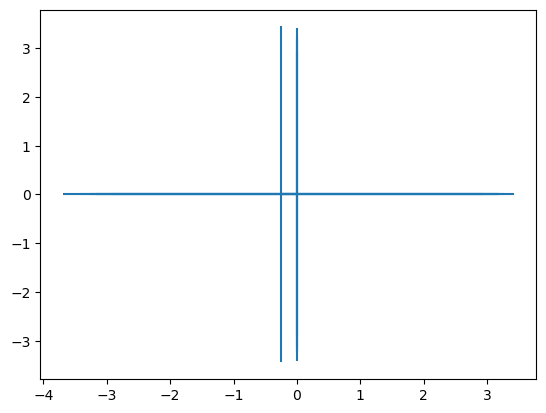

In [90]:
#display(paired_df['shift_x'].describe())
#display(paired_df['shift_y'].describe())
#display(paired_df['error'].describe())

display(paired_df)

def rms(series):
    if np.isnan(series).all():
        return np.nan  
    return np.sqrt(np.nansum(np.square(series)))

pdf = pd.DataFrame()
pdf['tile_mean_x'] = paired_df['shift_x'].agg(['mean'])
pdf['tile_mean_y'] = paired_df['shift_y'].agg(['mean'])
pdf['error'] = paired_df['error'].agg(rms)
#pdf = tdf.reset_index()
display(pdf)

plt.errorbar(pdf['tile_mean_x'], pdf['tile_mean_y'], yerr=pdf['error'], xerr=pdf['error']);

tile_mean_x  tile_mean_y     error
tile_number_x tile_number_y                                    
0             0                      0.0          0.0       NaN
              1                      0.0          0.0       NaN
              2                      0.0          0.0       NaN
              3                      0.0          0.0       NaN
              4                      0.0          0.0  0.809913
...                                  ...          ...       ...
7             3                      0.0          0.0  0.666656
              4                      0.0          0.0  0.646325
              5                      0.0          0.0       NaN
              6                      0.0          0.0       NaN
              7                      0.0          0.0       NaN

[64 rows x 3 columns]

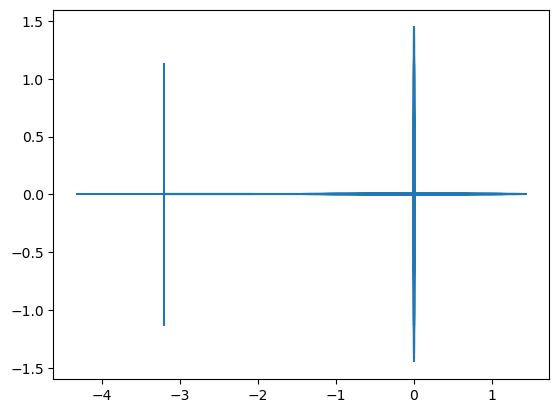

In [93]:
#display(temporal_df['shift_x'].describe())
#display(temporal_df['shift_y'].describe())
#display(temporal_df['error'].describe())

def rms(series):
    if np.isnan(series).all():
        return np.nan  
    return np.sqrt(np.nansum(np.square(series)))

tdf = pd.DataFrame()
tdf['tile_mean_x'] = temporal_df['shift_x'].agg(['mean'])
tdf['tile_mean_y'] = temporal_df['shift_y'].agg(['mean'])
tdf['error'] = temporal_df['error'].agg(rms)
display(tdf)

plt.errorbar(tdf['tile_mean_x'], tdf['tile_mean_y'], yerr=tdf['error'], xerr=tdf['error']);

In [89]:
display(global_df['shift_x'].describe())
display(global_df['shift_y'].describe())
display(global_df['error'].describe())

count  mean  std  min  25%  50%  \
reference_index tile_number_x tile_number_y                                    
0               0             1                1.0   0.0  NaN  0.0  0.0  0.0   
                              2                1.0   0.0  NaN  0.0  0.0  0.0   
                              3                1.0   0.0  NaN  0.0  0.0  0.0   
                              4                1.0   0.0  NaN  0.0  0.0  0.0   
                              5                1.0   0.0  NaN  0.0  0.0  0.0   
...                                            ...   ...  ...  ...  ...  ...   
4               7             3                1.0   0.0  NaN  0.0  0.0  0.0   
                              4                1.0   0.0  NaN  0.0  0.0  0.0   
                              5                1.0   0.0  NaN  0.0  0.0  0.0   
                              6                1.0   0.0  NaN  0.0  0.0  0.0   
                              7                1.0   0.0  NaN  0.0  0.0  0.0   

                                             75%  max  
reference_index tile_number_x tile_number_y            
0               0             1              0.0  0.0  
                              2              0.0  0.0  
                              3              0.0  0.0  
                              4              0.0  0.0  
                              5              0.0  0.0  
...                                          ...  ...  
4               7             3              0.0  0.0  
                              4              0.0  0.0  
                              5              0.0  0.0  
                              6              0.0  0.0  
                              7              0.0  0.0  

[319 rows x 8 columns]

count  mean  std  min  25%  50%  \
reference_index tile_number_x tile_number_y                                    
0               0             1                1.0   0.0  NaN  0.0  0.0  0.0   
                              2                1.0   0.0  NaN  0.0  0.0  0.0   
                              3                1.0   0.0  NaN  0.0  0.0  0.0   
                              4                1.0   0.0  NaN  0.0  0.0  0.0   
                              5                1.0   0.0  NaN  0.0  0.0  0.0   
...                                            ...   ...  ...  ...  ...  ...   
4               7             3                1.0   0.0  NaN  0.0  0.0  0.0   
                              4                1.0   0.0  NaN  0.0  0.0  0.0   
                              5                1.0   0.0  NaN  0.0  0.0  0.0   
                              6                1.0   0.0  NaN  0.0  0.0  0.0   
                              7                1.0   0.0  NaN  0.0  0.0  0.0   

                                             75%  max  
reference_index tile_number_x tile_number_y            
0               0             1              0.0  0.0  
                              2              0.0  0.0  
                              3              0.0  0.0  
                              4              0.0  0.0  
                              5              0.0  0.0  
...                                          ...  ...  
4               7             3              0.0  0.0  
                              4              0.0  0.0  
                              5              0.0  0.0  
                              6              0.0  0.0  
                              7              0.0  0.0  

[319 rows x 8 columns]

count      mean  std       min  \
reference_index tile_number_x tile_number_y                                   
0               0             1                0.0       NaN  NaN       NaN   
                              2                0.0       NaN  NaN       NaN   
                              3                0.0       NaN  NaN       NaN   
                              4                1.0  0.319314  NaN  0.319314   
                              5                1.0  0.310509  NaN  0.310509   
...                                            ...       ...  ...       ...   
4               7             3                1.0  0.290607  NaN  0.290607   
                              4                1.0  0.282643  NaN  0.282643   
                              5                0.0       NaN  NaN       NaN   
                              6                0.0       NaN  NaN       NaN   
                              7                0.0       NaN  NaN       NaN   

                                                  25%       50%       75%  \
reference_index tile_number_x tile_number_y                                 
0               0             1                   NaN       NaN       NaN   
                              2                   NaN       NaN       NaN   
                              3                   NaN       NaN       NaN   
                              4              0.319314  0.319314  0.319314   
                              5              0.310509  0.310509  0.310509   
...                                               ...       ...       ...   
4               7             3              0.290607  0.290607  0.290607   
                              4              0.282643  0.282643  0.282643   
                              5                   NaN       NaN       NaN   
                              6                   NaN       NaN       NaN   
                              7                   NaN       NaN       NaN   

                                                  max  
reference_index tile_number_x tile_number_y            
0               0             1                   NaN  
                              2                   NaN  
                              3                   NaN  
                              4              0.319314  
                              5              0.310509  
...                                               ...  
4               7             3              0.290607  
                              4              0.282643  
                              5                   NaN  
                              6                   NaN  
                              7                   NaN  

[319 rows x 8 columns]